# Naive Bayes

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import joblib
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats #Para la moda
## Gráfica tabla
from tempfile import TemporaryDirectory
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

## Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [2]:
def loadModel(name):    
    path = "../../Models/" + name + ".pkl"
    clf = joblib.load(path)
    
    return clf;

In [3]:
def saveModel(clf, name):
    path = "../../Models/" + name + ".pkl"
    joblib.dump(clf, "model.pkl")

In [4]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    return X,Y;

In [5]:
def loadHD5(name):
    path = '../../Tables/'
    path += name + '.h5'
    return pd.read_hdf(path, 'df').values

In [6]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [8]:
# F1
def model_NB_F1(impresion=True, classifier=None):    
       
    if classifier is not None:
        NB = classifier
    else:
        NB = GaussianNB()
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([5,2])
    accuracy_list_train = np.zeros([5,2])
    precision_list = np.zeros([5,2])
    precision_list_train = np.zeros([5,2])
    recall_list = np.zeros([5,2])
    recall_list_train = np.zeros([5,2])
    error = np.zeros([5,2])
    error_train = np.zeros([5,2])
    f_list = np.zeros([5,2]) 
    f1_train = np.zeros([5,2])
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, indexes in enumerate(skf.split(X, Y)):
        #Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2) # Modificar metodología de validación
        #scaler = MinMaxScaler() #Escala entre 0 y 1
        #Xtrain = scaler.fit_transform(Xtrain)
        #Xtest = scaler.transform(Xtest)
        
        Xtrain, Xtest = X[indexes[0]], X[indexes[1]]
        Ytrain, Ytest = Y[indexes[0]], Y[indexes[1]]

        #if classifier is None:
        #    mlp.fit(Xtrain, Ytrain)
        NB.fit(Xtrain, Ytrain)    
            
        pred = NB.predict(Xtest)
        pred_train = NB.predict(Xtrain)
        
        # accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[i] = _accuracy_

        _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        accuracy_list_train[i] = _accuracy_train_

        # recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[i] = _recalls_
        
        _recalls_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        recall_list_train[i] = _recalls_train_

        # precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[i] = _precisions_
        
        _precisions_train_ = precision_score(Ytrain, pred_train, average=None)
        precision_list_train[i] = _precisions_train_
        
        # f1
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[i] = _f_score_
        
        _f_score_train = f1_score(Ytrain, pred_train, average=None)
        f1_train[i] = _f_score_train
        
        # MAE
          
    if impresion:    
        #Curva ROC
        NB_probs = NB.predict_proba(Xtest)
        plot_roc(Xtest, Ytest, NB_probs, "NB")

        # Matriz Confusion
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)
        
        report = {
            'f1':[np.around(np.mean(f1_train), decimals=5), np.around(np.std(f1_train), decimals=5), np.around(np.mean(f_list), decimals=5), np.around(np.std(f_list), decimals=5)],
            'accuracy':[np.around(np.mean(accuracy_list_train), decimals=5), np.around(np.std(accuracy_list_train), decimals=5), np.around(np.mean(accuracy_list), decimals=5), np.around(np.std(accuracy_list), decimals=5)],
            'precision':[np.around(np.mean(precision_list_train), decimals=5), np.around(np.std(precision_list_train), decimals=5), np.around(np.mean(precision_list), decimals=5), np.around(np.std(precision_list), decimals=5)],
            'recall':[np.around(np.mean(recall_list_train), decimals=5), np.around(np.std(recall_list_train), decimals=5), np.around(np.mean(recall_list), decimals=5), np.around(np.std(recall_list), decimals=5)]
        }

        print(pd.DataFrame.from_dict(report, orient='index', columns=['Training score', '+/-', 'Test score', '+/-']))

        print("Total time:", time.time()-tiempo_i)

    return np.mean(f1_train), np.std(f1_train), np.mean(f_list), np.std(f_list), time.time()-tiempo_i;

## LSA, 10k, Sin caracteres especiales

In [9]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

In [ ]:
a, b, c, d, e = model_NB_F1()

In [ ]:
## Plot LC

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (LogisticRegression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

# Another stimator
#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                    cv=cv, n_jobs=4)

plt.show()

## LSA, 10k, sin caracteres especiales, 1500 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. 1500 tópicos.

In [17]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.598


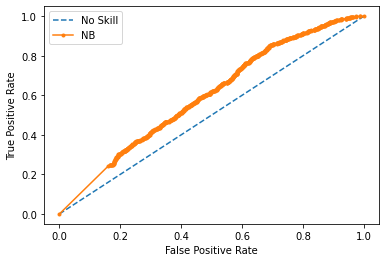

           Training score      +/-  Test score      +/-
f1                0.55120  0.06189     0.54623  0.06220
accuracy          0.55972  0.00160     0.55470  0.00463
precision         0.56464  0.01792     0.55914  0.01712
recall            0.55972  0.00160     0.55470  0.13671
Total time: 12.046922206878662


(0.5511970196275856,
 0.06188733783525127,
 0.5462267184503147,
 0.062199924758893674,
 12.047919988632202)

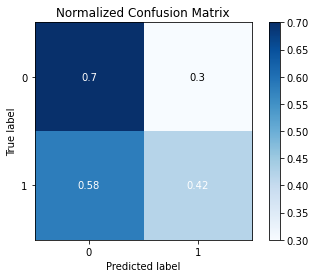

In [20]:
model_NB_F1()

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

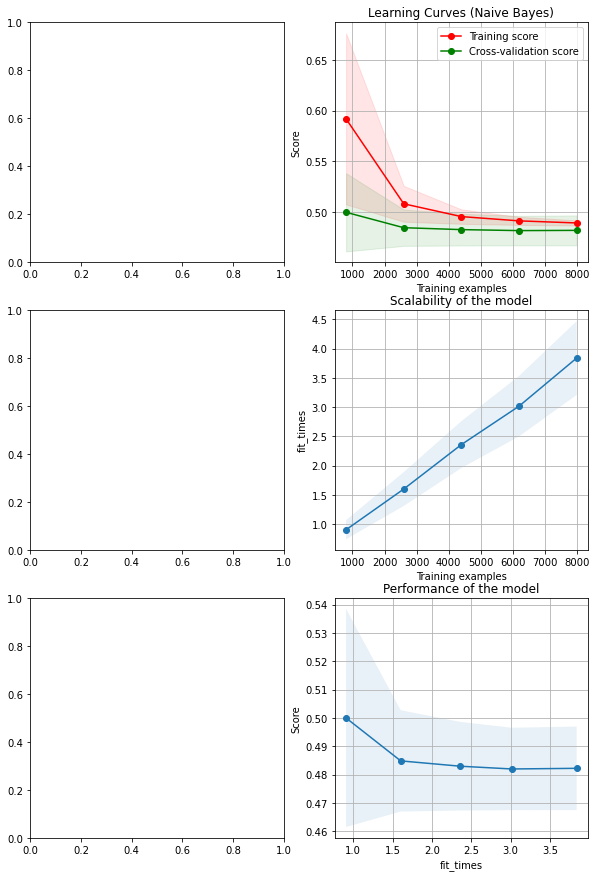

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

NB = GaussianNB()

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Naive Bayes)"

plot_learning_curve(NB, title, X, Y, axes=axes[:, 1], cv=cv, n_jobs=-1)

### Reduced features

#### Chi2 - 100 features

In [21]:
X = loadHD5('FS_Chi2_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.758


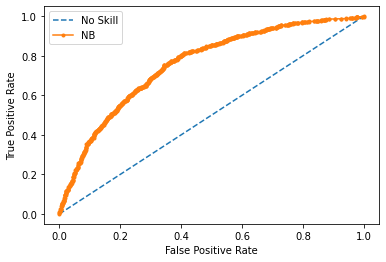

           Training score      +/-  Test score      +/-
f1                0.66356  0.03769     0.65572  0.03894
accuracy          0.66722  0.01169     0.65930  0.01508
precision         0.67461  0.03689     0.66594  0.03558
recall            0.66722  0.01169     0.65930  0.10231
Total time: 1.6019527912139893


(0.663555153779129,
 0.03768614004799877,
 0.6557238043411758,
 0.03893500634221579,
 1.602949619293213)

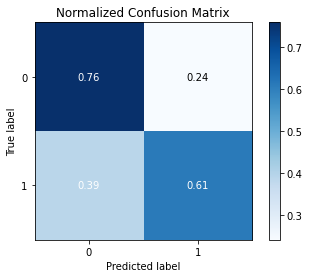

In [22]:
model_NB_F1()

#### F-value - 100

In [23]:
X = loadHD5('FS_Fisher_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.761


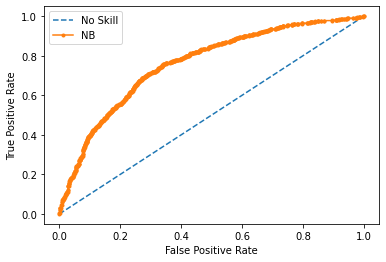

           Training score      +/-  Test score      +/-
f1                0.67770  0.03078     0.67344  0.03261
accuracy          0.67977  0.01449     0.67540  0.01872
precision         0.68418  0.03025     0.67932  0.03059
recall            0.67977  0.01449     0.67540  0.07836
Total time: 1.5041515827178955


(0.6776966228010353,
 0.030775427899132065,
 0.6734382285465996,
 0.03261249470360249,
 1.5041515827178955)

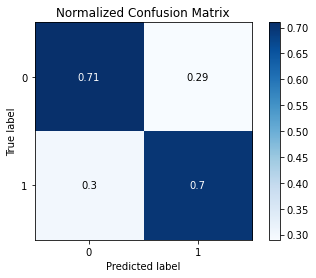

In [24]:
model_NB_F1()

#### Mutual Information - 100

In [25]:
X = loadHD5('FS_Mutual_Information_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.651


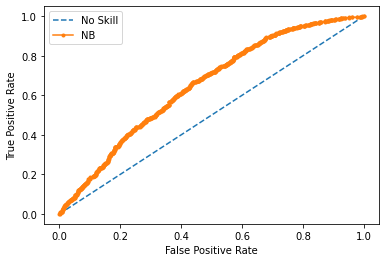

           Training score      +/-  Test score      +/-
f1                0.59383  0.04519     0.58735  0.04689
accuracy          0.59885  0.00147     0.59250  0.00746
precision         0.60399  0.02316     0.59731  0.02279
recall            0.59885  0.00147     0.59250  0.11179
Total time: 1.5619654655456543


(0.5938296694684443,
 0.04519171674834416,
 0.587351543701992,
 0.046894708047367055,
 1.5629639625549316)

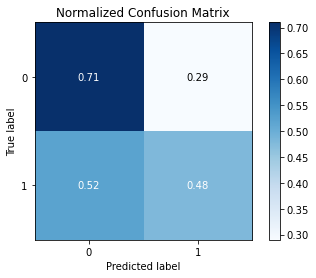

In [26]:
model_NB_F1()

#### LDA

In [27]:
X = loadHD5('LDA_LSA_1500')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.932


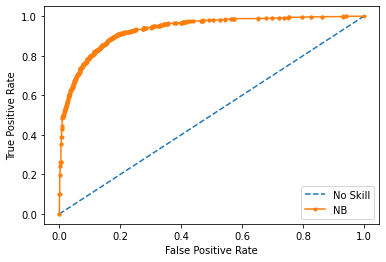

           Training score      +/-  Test score      +/-
f1                0.85317  0.00237     0.85338  0.00805
accuracy          0.85317  0.00206     0.85340  0.00791
precision         0.85327  0.00600     0.85355  0.01086
recall            0.85317  0.00206     0.85340  0.01310
Total time: 0.8456733226776123


(0.8531655844608841,
 0.0023718831416267233,
 0.8533841183370603,
 0.008052118358702254,
 0.8466718196868896)

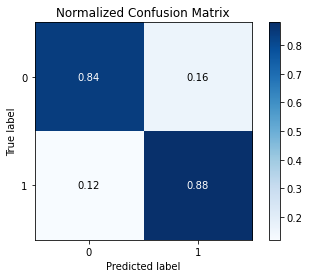

In [28]:
model_NB_F1()

#### PCA - 700

In [29]:
X = loadHD5('PCA_LSA_1500_700')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.685


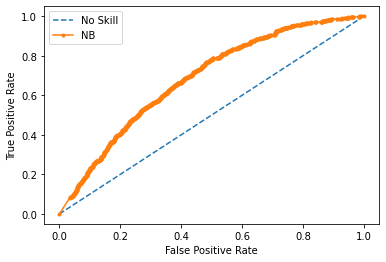

           Training score      +/-  Test score      +/-
f1                0.58869  0.06311     0.57931  0.06728
accuracy          0.59822  0.00663     0.58940  0.01512
precision         0.60820  0.03348     0.59879  0.03484
recall            0.59822  0.00663     0.58940  0.15540
Total time: 7.032628059387207


(0.5886921136576955,
 0.06311024946855408,
 0.5793077168792832,
 0.06727800148750952,
 7.033626079559326)

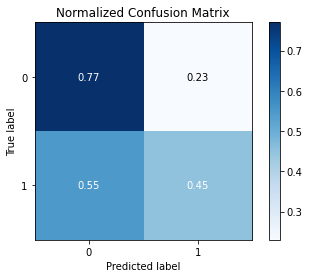

In [30]:
model_NB_F1()

#### SFS (Wrapper) - 100

In [12]:
sfs = loadModel('SFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sfs.k_feature_idx_]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.641


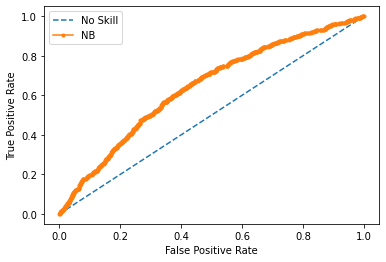

           Training score      +/-  Test score      +/-
f1                0.65675  0.03225     0.62869  0.03307
accuracy          0.65872  0.01641     0.63080  0.01739
precision         0.66207  0.02675     0.63391  0.02766
recall            0.65872  0.01641     0.63080  0.07740
Total time: 0.7461338043212891


(0.6567468112695659,
 0.032252164199127936,
 0.6286851397605683,
 0.03307267995473525,
 0.7464783191680908)

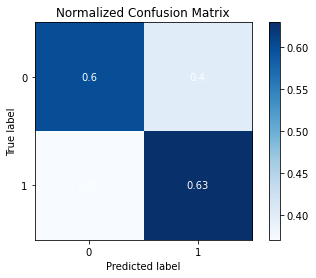

In [13]:
model_NB_F1()

#### SFFS (Wrapper) - 100

In [14]:
sffs = loadModel('SFFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sffs.k_feature_idx_]

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.662


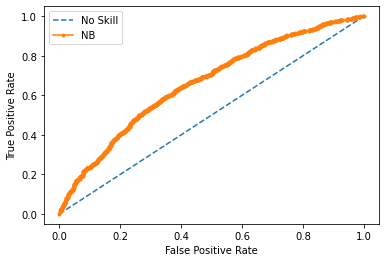

           Training score      +/-  Test score      +/-
f1                0.57772  0.07270     0.57058  0.07430
accuracy          0.59015  0.00540     0.58310  0.01087
precision         0.60218  0.03562     0.59405  0.03463
recall            0.59015  0.00540     0.58310  0.17102
Total time: 0.6413671970367432


(0.577716213293175,
 0.07269776102005089,
 0.5705779697936743,
 0.07430472491697214,
 0.6413671970367432)

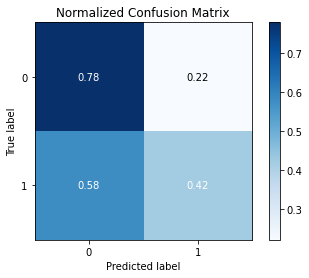

In [15]:
model_NB_F1()

#### Pearson correlation coefficient - 101

In [16]:
X = loadHD5('PEARSON_LSA_1500_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.667


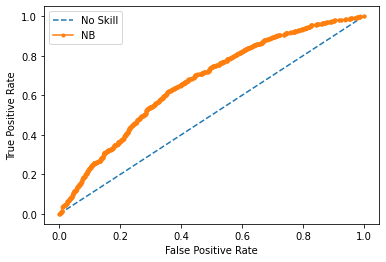

           Training score      +/-  Test score      +/-
f1                0.59872  0.04708     0.58960  0.04938
accuracy          0.60390  0.00880     0.59470  0.01639
precision         0.60937  0.02525     0.59941  0.02675
recall            0.60390  0.00880     0.59470  0.11210
Total time: 0.5828123092651367


(0.59871663178275,
 0.0470831425694805,
 0.589597118455458,
 0.04937943208064923,
 0.5828123092651367)

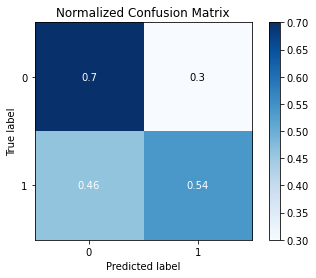

In [17]:
model_NB_F1()

# Doc2Vec

In [9]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

In [10]:
X = loadHD5('Doc2Vec')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.626


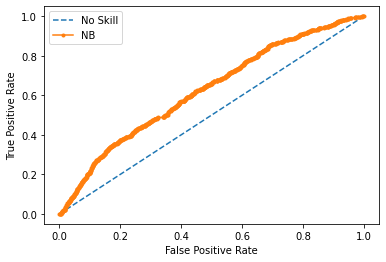

           Training score      +/-  Test score      +/-
f1                0.56895  0.05076     0.55713  0.05566
accuracy          0.57482  0.00595     0.56320  0.02019
precision         0.57911  0.01937     0.56696  0.02731
recall            0.57482  0.00595     0.56320  0.11890
Total time: 3.8775737285614014


(0.5689499314184201,
 0.05075914509595565,
 0.5571281494217988,
 0.05566168438780297,
 3.878542184829712)

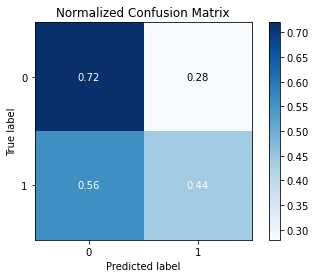

In [11]:
model_NB_F1()

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

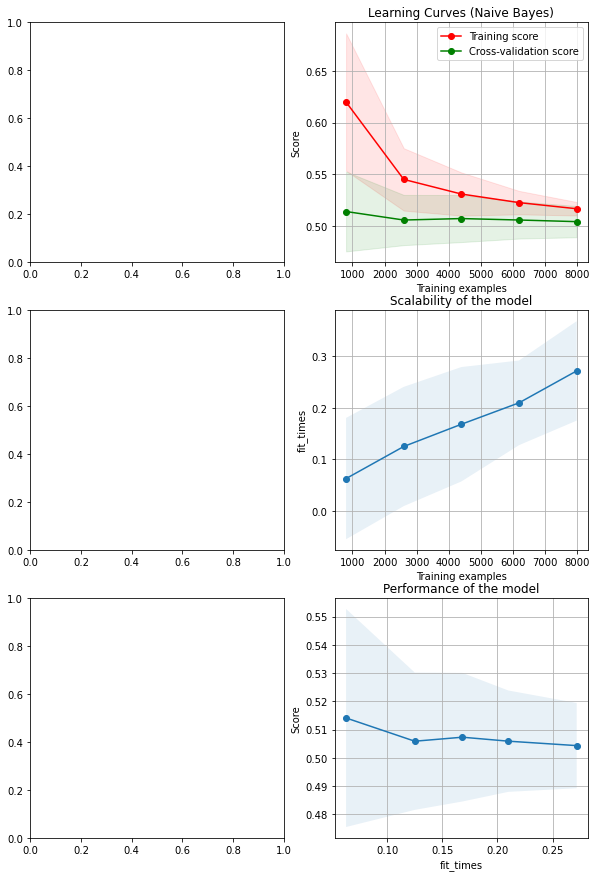

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

NB = GaussianNB()

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Naive Bayes)"

plot_learning_curve(NB, title, X, Y, axes=axes[:, 1], cv=cv, n_jobs=-1)